In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans

In [2]:
sales = pd.read_csv("rollingsales_brooklyn.csv")
print(len(sales))
sales.dtypes

23373


BOROUGH                            int64
NEIGHBORHOOD                      object
BUILDING CLASS CATEGORY           object
TAX CLASS AT PRESENT              object
BLOCK                              int64
LOT                                int64
EASE-MENT                         object
BUILDING CLASS AT PRESENT         object
ADDRESS                           object
APARTMENT NUMBER                  object
ZIP CODE                           int64
RESIDENTIAL UNITS                  int64
COMMERCIAL UNITS                   int64
TOTAL UNITS                        int64
LAND SQUARE FEET                  object
GROSS SQUARE FEET                 object
YEAR BUILT                         int64
TAX CLASS AT TIME OF SALE          int64
BUILDING CLASS AT TIME OF SALE    object
SALE PRICE                        object
SALE DATE                         object
dtype: object

In [3]:
# Format columns
def format_num(s):
    return float(s.replace("$","").replace(",",""))

# Strip extra whitespace from strings
# Could also go further and convert everything to lowercase, collapse extra internal spaces, etc...
str_cols = sales.select_dtypes(["object"])
sales[str_cols.columns] = str_cols.apply(lambda x: x.str.strip())

# Format numbers that have dollar signs and or commas so they can actually be treated as numbers
num_cols = sales[["LAND SQUARE FEET", "SALE PRICE", "GROSS SQUARE FEET"]]
sales[num_cols.columns] = num_cols.apply(lambda x: x.apply(format_num,True))

# Turn date string into an actual date object
sales["SALE DATE"] = pd.to_datetime(sales["SALE DATE"])

In [4]:
sales.dtypes

BOROUGH                                    int64
NEIGHBORHOOD                              object
BUILDING CLASS CATEGORY                   object
TAX CLASS AT PRESENT                      object
BLOCK                                      int64
LOT                                        int64
EASE-MENT                                 object
BUILDING CLASS AT PRESENT                 object
ADDRESS                                   object
APARTMENT NUMBER                          object
ZIP CODE                                   int64
RESIDENTIAL UNITS                          int64
COMMERCIAL UNITS                           int64
TOTAL UNITS                                int64
LAND SQUARE FEET                         float64
GROSS SQUARE FEET                        float64
YEAR BUILT                                 int64
TAX CLASS AT TIME OF SALE                  int64
BUILDING CLASS AT TIME OF SALE            object
SALE PRICE                               float64
SALE DATE           

In [5]:
# Select features we are interested in
sales = sales[["NEIGHBORHOOD", "BUILDING CLASS CATEGORY", "LAND SQUARE FEET", "GROSS SQUARE FEET", "YEAR BUILT", "SALE PRICE"]]
# Add a new feature for the total square feet
sales["TOTAL SQUARE FEET"] = sales["LAND SQUARE FEET"] + sales["GROSS SQUARE FEET"]
sales.describe()

,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE,TOTAL SQUARE FEET
count,2.337300e+04,2.337300e+04,23373.000000,2.337300e+04,2.337300e+04
mean,3.558953e+03,3.005280e+03,1681.096436,5.283847e+05,6.564233e+03
std,7.830975e+04,2.295111e+04,658.095440,2.821726e+06,8.947425e+04
min,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,1901.000000,0.000000e+00,0.000000e+00
50%,1.850000e+03,1.760000e+03,1925.000000,2.500000e+05,3.813000e+03
75%,2.500000e+03,3.000000e+03,1950.000000,6.141970e+05,5.374000e+03
max,7.446955e+06,2.548000e+06,2013.000000,2.769470e+08,8.992663e+06


In [6]:
# Based on the above summary data (and prior EDA!!!), we should get rid of some missing/invalid data
sales = sales[sales["NEIGHBORHOOD"] != ""]
sales = sales[sales["BUILDING CLASS CATEGORY"] != ""]
sales = sales[sales["LAND SQUARE FEET"] > 0]
sales = sales[sales["GROSS SQUARE FEET"] > 0]
sales = sales[sales["YEAR BUILT"] > 1900]
sales = sales[sales["SALE PRICE"] > 10000]
sales.describe()

,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE,TOTAL SQUARE FEET
count,7101.000000,7.101000e+03,7101.000000,7.101000e+03,7.101000e+03
mean,3555.689621,4.851353e+03,1930.487255,1.046705e+06,8.407042e+03
std,17424.871027,3.320359e+04,25.220956,4.159173e+06,4.757257e+04
min,396.000000,1.000000e+02,1901.000000,1.100000e+04,8.320000e+02
25%,1890.000000,1.824000e+03,1915.000000,3.900000e+05,3.896000e+03
50%,2080.000000,2.515000e+03,1925.000000,6.000000e+05,4.862000e+03
75%,2715.000000,3.572000e+03,1931.000000,8.800000e+05,6.250000e+03
max,905000.000000,2.548000e+06,2012.000000,2.769470e+08,3.453000e+06


<AxesSubplot:xlabel='GROSS SQUARE FEET', ylabel='SALE PRICE'>

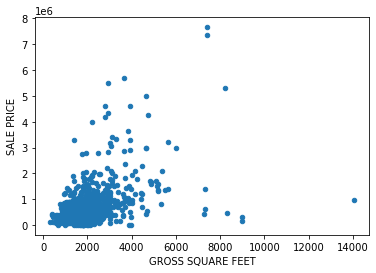

In [7]:
# Now that our data has been cleaned up (and prior EDA was done!), lets look
# at predicting sale prices for single family homes
single_family = sales[sales["BUILDING CLASS CATEGORY"] == "01  ONE FAMILY HOMES"]
single_family.plot.scatter(x="GROSS SQUARE FEET", y="SALE PRICE")

<AxesSubplot:xlabel='GROSS SQUARE FEET', ylabel='SALE PRICE'>

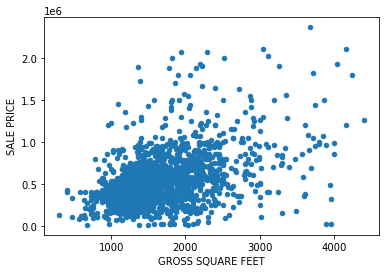

In [8]:
# There are some pretty extreme outliers, let's filter out data more than 3 std devs from mean
single_family = single_family[(np.abs(stats.zscore(single_family[["GROSS SQUARE FEET","LAND SQUARE FEET","SALE PRICE"]])) < 3).all(axis=1)]
single_family.plot.scatter(x="GROSS SQUARE FEET", y="SALE PRICE")

0.19047762405444346

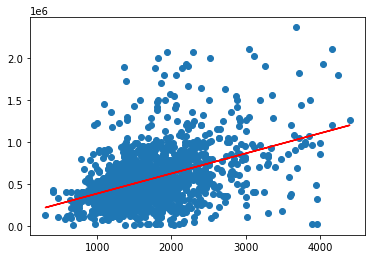

In [9]:
# Now lets try to fit a linear relationship between sq ft and sale price
x = single_family["GROSS SQUARE FEET"].values.reshape(-1, 1)
y = single_family["SALE PRICE"].values.reshape(-1, 1)

# Split our data into a training set and test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25,random_state=42)

# Fit our model based on training data
model = LinearRegression()
model.fit(x_train, y_train)

# Plot the data and the regression line
plt.scatter(x, y)
plt.plot(x, model.predict(x), color='red')

# Check R^2 of our test data
model.score(x_test,y_test)

0.2376599640674052

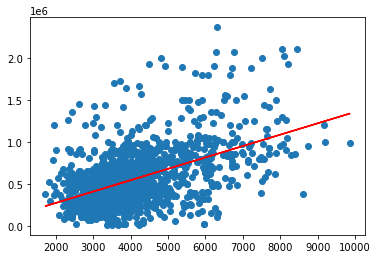

In [10]:
# Last fit was not so good...maybe total square feet is a better predictor for sale price
x = single_family["TOTAL SQUARE FEET"].values.reshape(-1, 1)
y = single_family["SALE PRICE"].values.reshape(-1, 1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25,random_state=42)

model = LinearRegression()
model.fit(x_train, y_train)
plt.scatter(x, y)
plt.plot(x, model.predict(x), color='red')
model.score(x_test,y_test)

In [11]:
sales["NEIGHBORHOOD"].value_counts()

BUSHWICK                 491
BEDFORD STUYVESANT       482
EAST NEW YORK            386
BOROUGH PARK             356
CROWN HEIGHTS            337
                        ... 
DOWNTOWN-FULTON FERRY      9
SEAGATE                    8
COBBLE HILL-WEST           7
JAMAICA BAY                1
DOWNTOWN-METROTECH         1
Name: NEIGHBORHOOD, Length: 61, dtype: int64

<AxesSubplot:xlabel='TOTAL SQUARE FEET', ylabel='SALE PRICE'>

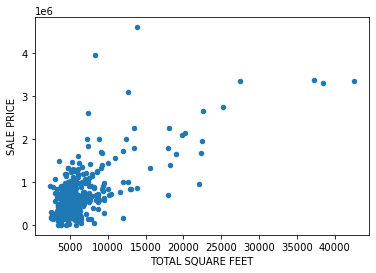

In [12]:
# Total square feet is better, but still not great
# The data comes from 61 different neighborhoods, and as they say "location location location!"...so
# the neighborhood probably has a pretty big effect on price. Let's look at just a single neighborhood.
sales_bedstuy = sales[sales["NEIGHBORHOOD"]=="BEDFORD STUYVESANT"]
sales_bedstuy = sales_bedstuy[(np.abs(stats.zscore(sales_bedstuy[["GROSS SQUARE FEET","LAND SQUARE FEET","SALE PRICE"]])) < 3).all(axis=1)]
sales_bedstuy.plot.scatter(x="TOTAL SQUARE FEET", y="SALE PRICE")

0.5178315676790148

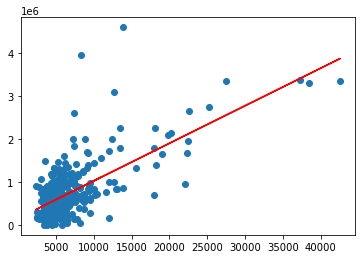

In [13]:
# Fit a model to predict sale price in Bed-Stuy based on total square footage
x = sales_bedstuy["TOTAL SQUARE FEET"].values.reshape(-1, 1)
y = sales_bedstuy["SALE PRICE"].values.reshape(-1, 1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25,random_state=42)

model = LinearRegression()
model.fit(x_train, y_train)
plt.scatter(x, y)
plt.plot(x, model.predict(x), color='red')
model.score(x_test,y_test)

In [14]:
# That's much better (although still probably not great)
# What if we fit based on two predictors instead of one?
x = sales_bedstuy[["GROSS SQUARE FEET","LAND SQUARE FEET"]].values
y = sales_bedstuy["SALE PRICE"].values.reshape(-1, 1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25,random_state=42)

model = LinearRegression()
model.fit(x_train, y_train)
model.score(x_test,y_test)

0.5210720893992498

0.7414863584827611

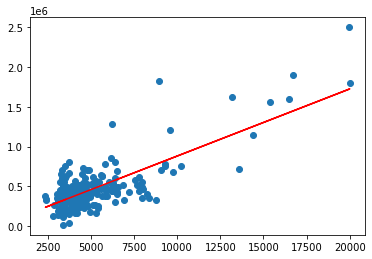

In [25]:
sales_flatbush = sales[sales["NEIGHBORHOOD"]=="FLATBUSH-EAST"]
sales_flatbush = sales_flatbush[(np.abs(stats.zscore(sales_flatbush[["GROSS SQUARE FEET","LAND SQUARE FEET","SALE PRICE"]])) < 3).all(axis=1)]
x = sales_flatbush["TOTAL SQUARE FEET"].values.reshape(-1,1)
y = sales_flatbush["SALE PRICE"].values.reshape(-1, 1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25,random_state=42)

model = LinearRegression()
model.fit(x_train, y_train)
plt.scatter(x, y)
plt.plot(x, model.predict(x), color='red')
model.score(x_test,y_test)

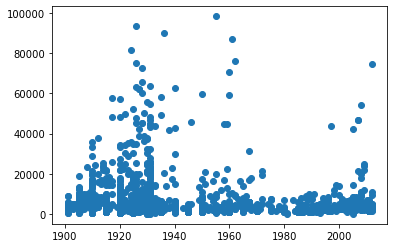

In [16]:
# Now, lets try to cluster our data, based on year and square footage
sales_3std = sales[(np.abs(stats.zscore(sales[["GROSS SQUARE FEET","LAND SQUARE FEET","SALE PRICE"]])) < 3).all(axis=1)]
plt.scatter(sales_3std["YEAR BUILT"], sales_3std["GROSS SQUARE FEET"])

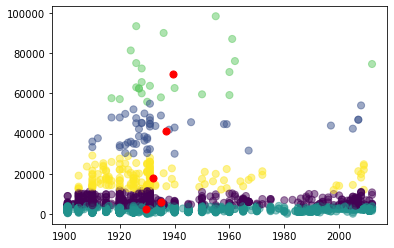

In [17]:
# Set up our KMeans model to find 5 clusters in the data
kmeans = KMeans(n_clusters = 5).fit(sales_3std[["YEAR BUILT", "GROSS SQUARE FEET"]])

# Plot the centroids and clusters
plt.scatter(sales_3std["YEAR BUILT"], sales_3std["GROSS SQUARE FEET"], c=kmeans.labels_.astype(float), s=50, alpha=0.5)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], c='red', s=50)

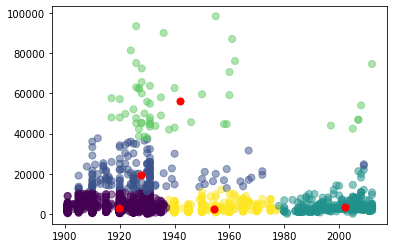

In [18]:
# Clusters seem entirely dependent on square footage, and not year at all...why could this be?
# Scale of the data! The difference in square footage is at a far larger scale than build year.
# Let's scale our data and try again...
scaler = StandardScaler()
scaled_kmeans = pd.DataFrame(scaler.fit_transform(sales_3std[["YEAR BUILT", "GROSS SQUARE FEET"]]),columns=["YEAR BUILT","GROSS SQUARE FEET"])

kmeans = KMeans(n_clusters = 5).fit(scaled_kmeans)
centroids = scaler.inverse_transform(kmeans.cluster_centers_)
plt.scatter(sales_3std["YEAR BUILT"], sales_3std["GROSS SQUARE FEET"], c=kmeans.labels_.astype(float), s=50, alpha=0.5)
plt.scatter(centroids[:,0], centroids[:,1], c='red', s=50)

In [24]:
# How can we interpret the above results? That's the tricky part.
# It may require some domain knowledge.
# Perhaps in this case, very large properties fall into a category that doesn't really depend on year.
# Whereas the more modestly sized properties have more significant difference based on when they were built?
# Probably need to look at more attributes. Maybe the largest category also corresponds to a different category
# of building, etc.